### Download the dataset

In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-04-18 05:43:44--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  6.72MB/s    in 0.8s    

2023-04-18 05:43:45 (6.72 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [2]:
import json

with open('sarcasm.json', 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []
for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

### Hyperparameters

In [3]:
training_size = 20000
vocab_size = 10000
max_length = 32
embedding_dim = 16

### Split the dataset

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

### Preprocessing the train and test sets

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_tok = '<OOV>'
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [24]:
testing_labels[5]

1

In [6]:
# find the longest sentence
i = []
for item in testing_sentences:
  i.append(len(item))

max(i)

228

### Build and Compile the Model

In [7]:
import tensorflow as tf

gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

sample_array = np.array([[[10,2],[1,3],[1,1]]])
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

output = gap1d_layer(sample_array)
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [10]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.5660 - accuracy: 0.6975 - val_loss: 0.4069 - val_accuracy: 0.8302 - 3s/epoch - 5ms/step
Epoch 2/30
625/625 - 2s - loss: 0.3147 - accuracy: 0.8756 - val_loss: 0.3534 - val_accuracy: 0.8457 - 2s/epoch - 4ms/step
Epoch 3/30
625/625 - 2s - loss: 0.2345 - accuracy: 0.9079 - val_loss: 0.3491 - val_accuracy: 0.8551 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 3s - loss: 0.1885 - accuracy: 0.9276 - val_loss: 0.3706 - val_accuracy: 0.8506 - 3s/epoch - 5ms/step
Epoch 5/30
625/625 - 2s - loss: 0.1558 - accuracy: 0.9416 - val_loss: 0.4257 - val_accuracy: 0.8375 - 2s/epoch - 3ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1315 - accuracy: 0.9524 - val_loss: 0.4293 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1111 - accuracy: 0.9628 - val_loss: 0.4732 - val_accuracy: 0.8435 - 2s/epoch - 4ms/step
Epoch 8/30
625/625 - 2s - loss: 0.0969 - accuracy: 0.9673 - val_loss: 0.5538 - val_accuracy: 0.8331 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 3s 

In [12]:
model.save('my_model.h5')

### Visualize the Results

In [50]:
new_model = tf.keras.models.load_model('my_model.h5')
answer = new_model(testing_padded[1:2, :])


### Visualize Word Embeddings

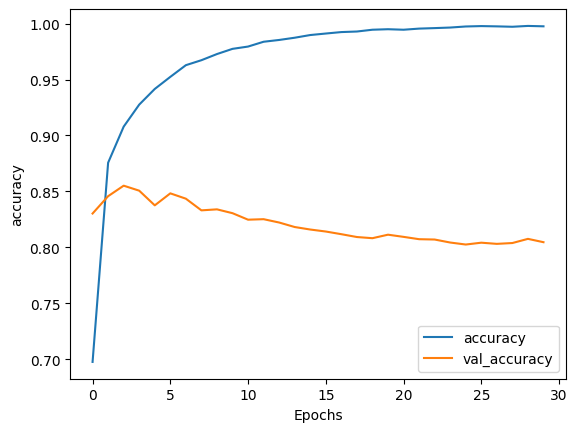

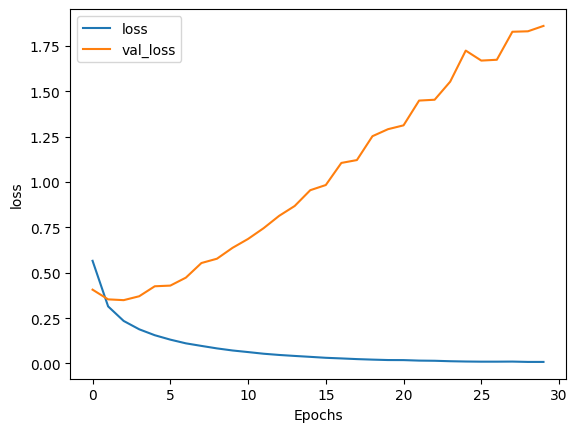

In [30]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

In [29]:
history.history['accuracy']

[0.6975499987602234,
 0.8756499886512756,
 0.9078999757766724,
 0.9276000261306763,
 0.9416000247001648,
 0.9524000287055969,
 0.9628499746322632,
 0.9672999978065491,
 0.9728000164031982,
 0.9774500131607056,
 0.9794999957084656,
 0.9837999939918518,
 0.9854000210762024,
 0.9873999953269958,
 0.989799976348877,
 0.9911500215530396,
 0.9924499988555908,
 0.9929500222206116,
 0.9945499897003174,
 0.9950000047683716,
 0.9945499897003174,
 0.9955499768257141,
 0.9959999918937683,
 0.9965000152587891,
 0.9974499940872192,
 0.9977999925613403,
 0.9975500106811523,
 0.9972000122070312,
 0.99795001745224,
 0.9976000189781189]

### Visualize Word Embeddings

In [38]:
reverse_word_index = tokenizer.index_word

embedding_layer = model.layers[0]

embedding_weights = embedding_layer.get_weights()

print((embedding_layer.input_length)) 

32


In [41]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

In [43]:
a[1, :]

array([4, 5, 6])

In [45]:
a.shape

(2, 3)